In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from Utilities import PlotImages

In [2]:
def buildCustomModel(input_shape, output, convolutionalRegions=5, layersInRegion=3):
    model = Sequential()
    
    model.add(Conv2D(10,3,
                     padding='same', 
                     input_shape=input_shape,
                     activation='relu'))
    
    for regionNum in range(convolutionalRegions):
        for layerNum in range(layersInRegion):
            model.add(Conv2D((2**(regionNum+1))*10,3,
                     padding='same',
                     activation='relu'))
        model.add(Dropout(.15))
        model.add(MaxPooling2D(pool_size=(2,2),
                     strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dense(output,
                     activation='softmax'))
    return model

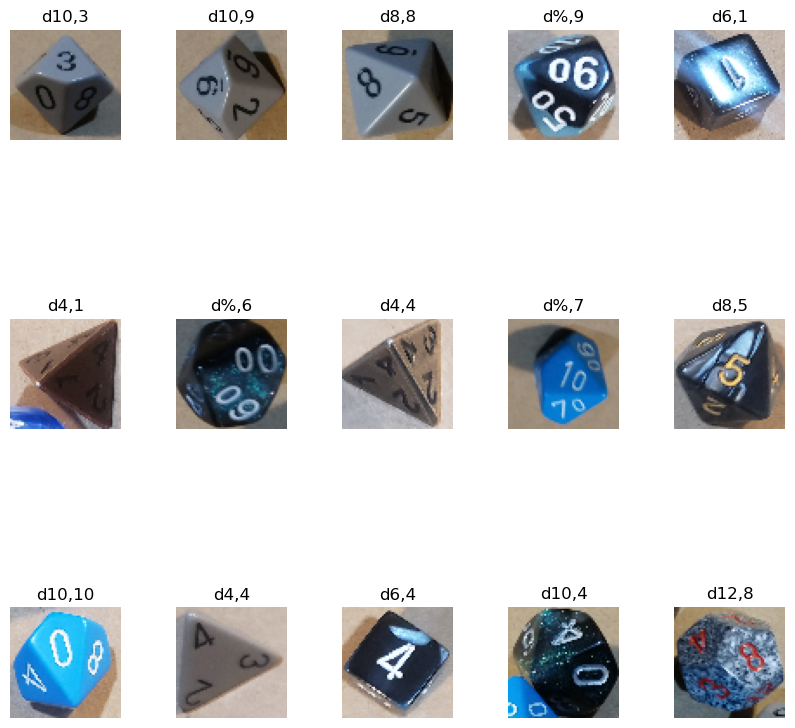

In [3]:
data = np.load("/work/MA490_DeepLearning/Share/Dice/RotatedDiceImages64pix.npz", allow_pickle=True)
images = data["images"]
labels = data["labels"]
perm = np.random.RandomState(seed=0).permutation(images.shape[0])
images = images[perm,:,:]
labels = labels[perm]
images_train = images[0:-200,:,:]
labels_train = labels[0:-200]
images_test = images[-200:,:,:]
labels_test = labels[-200:]
PlotImages(0, 15, 3, 5, images, labels)
plt.show()

In [4]:
print(images_train.shape)
print(images_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(10872, 64, 64, 3)
(200, 64, 64, 3)
(10872,)
(200,)


In [5]:
typeOfDice = 8
d6images = []
d6labels = []
for i in range(len(images_train)):
    split = labels_train[i].split(",")
    if len(split) != 2:
        continue
    (diceType, diceValue) = split
    if diceType == "d"+str(typeOfDice) and diceValue.isnumeric() and int(diceValue) < typeOfDice+1:
        d6images.append(images_train[i])
        d6labels.append(diceValue)
        
d6images = np.array(d6images)
d6labels = np.array(d6labels)
PlotImages(0, 15, 3, 5, d6images, d6labels)
plt.show()

In [6]:
numTest = 40
d6imagesTest = d6images[:numTest]
d6labelsTest = d6labels[:numTest]
d6images = d6images[numTest:]
d6labels = d6labels[numTest:]

In [7]:
print(d6images.shape)
print(type(d6labels[0]))
X = d6images
y = np.array(list(map(lambda x: float(x) - 1, d6labels)))
# X = images
# y = np.array(list(map(lambda x: float(x) - 1, labels)))
# y = to_categorical(y)

(1159, 64, 64, 3)
<class 'numpy.str_'>


In [8]:
y.shape

(1159,)

In [9]:
###################
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
###################

In [10]:
customModel = buildCustomModel((64,64,3), typeOfDice, 5, 1)

customModel.compile(loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0005),
        metrics=['accuracy'])

In [11]:
checkpt = ModelCheckpoint("d" + str(typeOfDice),
                         save_best_only=True,
                         verbose=0)

In [12]:
customModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 10)        280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 20)        1820      
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 40)        7240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 40)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 40)        0

In [13]:
with tf.device('/device:GPU:5'):
    hist = customModel.fit(X,y,
            epochs=50,
            callbacks=[checkpt],
            validation_split=0.2,
            verbose=2)

Epoch 1/50
29/29 - 110s - loss: 2.0738 - accuracy: 0.1435 - val_loss: 2.0668 - val_accuracy: 0.1681
INFO:tensorflow:Assets written to: d8/assets
Epoch 2/50
29/29 - 0s - loss: 2.0655 - accuracy: 0.1640 - val_loss: 2.0642 - val_accuracy: 0.1681
INFO:tensorflow:Assets written to: d8/assets
Epoch 3/50
29/29 - 0s - loss: 2.0608 - accuracy: 0.1640 - val_loss: 2.0637 - val_accuracy: 0.1681
INFO:tensorflow:Assets written to: d8/assets
Epoch 4/50
29/29 - 0s - loss: 2.0555 - accuracy: 0.1640 - val_loss: 2.0573 - val_accuracy: 0.1681
INFO:tensorflow:Assets written to: d8/assets
Epoch 5/50
29/29 - 0s - loss: 2.0617 - accuracy: 0.1640 - val_loss: 2.0682 - val_accuracy: 0.1724
Epoch 6/50
29/29 - 0s - loss: 2.0592 - accuracy: 0.1780 - val_loss: 2.0590 - val_accuracy: 0.1681
Epoch 7/50
29/29 - 0s - loss: 2.0575 - accuracy: 0.1640 - val_loss: 2.0613 - val_accuracy: 0.1681
Epoch 8/50
29/29 - 0s - loss: 2.0667 - accuracy: 0.1575 - val_loss: 2.0579 - val_accuracy: 0.1681
Epoch 9/50
29/29 - 0s - loss: 2.05

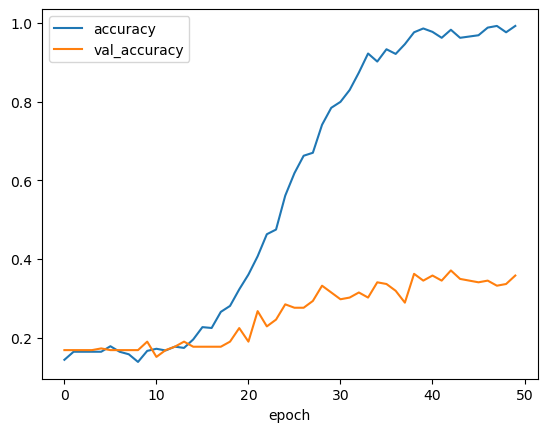

In [14]:
results = pd.DataFrame()
results["epoch"] = hist.epoch
results["accuracy"] = hist.history["accuracy"]
results["val_accuracy"] = hist.history["val_accuracy"]
plot1 = results.plot.line(x="epoch", y="accuracy")
results.plot.line(x="epoch", y="val_accuracy", ax=plot1)
plt.show()

In [15]:
print(results['val_accuracy'].max())

0.37068966031074524
